In [42]:
import sugar_analysis as sa
import sncosmo  
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt

# Load SUGAR

In [18]:
sa.register_SUGAR(modeldir= '../../sugar_model/')

# Load new filter and new magnitude system

## Load filter

In [19]:
def new_filter(wavel, trans, band_name):
    """
    Register new filter in sncosmo.
    wavel : array 
            wavelength in A
    trans : array
            transmission
    band_name : str
                name of this filter in sncosmo
    """
    band = sncosmo.Bandpass(wavel, trans, wave_unit=u.AA, name=band_name)    
    sncosmo.registry.register(band, force=True)

## Load Magnitude system 

In [21]:
def new_mag_sys(name, path_ref_spectrum, set_band_name):
        """
        Register in sncosmo new magnitude based on a set of filters and a reference spectrum
        name : str
               name register in sncosmo for ths magnitude system
        path_ref_spectrum : str
                            path to reference spectrum, file need to be a .dat or .ascii 
                            with first colum wavelenght and flux density on second colum
        set_band_name : list of band name
                        All this name have to be register in sncosmo
        """
        def load_spectral_magsys(relpath, name=None, version=None):
            """
            load reference spectrum in sncosmo
            """
            data = np.genfromtxt(relpath)
            dispersion = data[:,0]
            flux_density = data[:,1]
            refspectrum = sncosmo.spectrum.Spectrum(dispersion, flux_density,
                                   unit=(u.erg / u.s / u.cm**2 / u.AA), wave_unit=u.AA)
            return sncosmo.magsystems.SpectralMagSystem(refspectrum, name=name)
        
        sncosmo.registry.register_loader(sncosmo.MagSystem, 'spec_ref', load_spectral_magsys,
                                 args=[path_ref_spectrum], force=True)
        set_band = {}
        
        for b in set_band_name:
            set_band[b] = ('spec_ref', 0)  #shift between the magnitude system using 'spec ref' as reference 
                                       #and the final magnitude system 0 by default
        sncosmo.registry.register(sncosmo.CompositeMagSystem(bands=set_band), name, force=True)
            
        

## Exemple

### Load filters

In [23]:
wavel_B = np.arange(4102,5100,1.)
wavel_V = np.arange(5200,6290,1.)
wavel_R = np.arange(6289,7607,1.)
trans_B = np.ones_like(wavel_B)
trans_V = np.ones_like(wavel_V)
trans_R = np.ones_like(wavel_R)
trans[0] = 0.0
trans[len(trans)-1] = 0.0
new_filter(wavel_B, trans_B, 'band_B')
new_filter(wavel_V, trans_V, 'band_V')
new_filter(wavel_R, trans_R, 'band_R')

### Load mag sys

In [24]:
set_band_name = ['band_B','band_V','band_R']
new_mag_sys('mag_sys', '../../sugar_analysis_data/data/MagSys/bd_17d4708_stisnic_002.ascii', set_band_name)

# Define SUGAR or SALT2 model for a given set of parameter

## Set SALT2 and SUGAR parameters 

In [25]:
#array like np.array([zhl, t0, x1, c, mwebv]) or np.array([zhl, t0, q1, q2, q3, A, mwebv])

# SALT2 
param_salt2 = np.array([0., 0., 0., 0., 0.])

#SUGAR
param_sugar = np.array([0., 0., 0., 0., 0., 0., 0.])

## Register SALT2 model

In [31]:
salt2_source = sncosmo.get_source('salt2', version='2.4')
dust = sncosmo.CCM89Dust()
salt2_model = sncosmo.Model(source=salt2_source, 
                              effects=[dust], 
                              effect_names=['mw'], 
                              effect_frames=['obs'])   
salt2_model.set(z=param_salt2[0], t0=param_salt2[1], x1=param_salt2[2], c=param_salt2[3], mwebv=param_salt2[4])

## Register SUGAR model 

In [33]:
sugar_source = sncosmo.get_source('sugar')
dust = sncosmo.CCM89Dust()
sugar_model = sncosmo.Model(source=sugar_source, 
                              effects=[dust], 
                              effect_names=['mw'], 
                              effect_frames=['obs'])   
sugar_model.set(z=param_sugar[0], t0=param_sugar[1], 
                q1=param_sugar[2], q2=param_sugar[3],
                q3=param_sugar[4], A=param_sugar[5],
                mwebv=param_sugar[6])

# Compute SUGAR or SALT2 light curve in a given band

## get band from sncosmo 

In [39]:
band_B = sncosmo.get_bandpass('band_B') #one of the name bands define previously

## Compute SUGAR or SALT2 band flux for different phase

In [60]:
time = np.arange(-10, 48, 1.)

#in flux
band_flux_sugar = sugar_model.bandflux(band_B, time)
band_flux_salt2 = salt2_model.bandflux(band_B, time)

#in mag
band_mag_sugar = sugar_model.bandmag(band_B, 'mag_sys', time) #magsys name
band_mag_salt2 = salt2_model.bandmag(band_B, 'mag_sys',time)

In [61]:
band_mag_sugar = sugar_model.bandmag

## Plot light curves

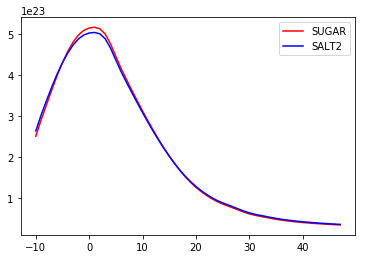

In [62]:
plt.plot(time, band_flux_sugar, label='SUGAR', c='r')
plt.plot(time, band_flux_salt2, label='SALT2', c='b')
plt.legend()
plt.show()

# Compute SUGAR or SALT2 spectra at a given time

In [67]:
time = 0.
wavel = np.arange(3255,8649, 1.)

#in flux
band_flux_sugar = sugar_model.flux(time, wavel)
band_flux_salt2 = salt2_model.flux(time, wavel)

#in AB mag
band_mag_sugar =  -2.5*np.log10(band_flux_sugar*(wavel ** 2 / 299792458. * 1.e-10))
band_mag_salt2 = -2.5*np.log10(band_flux_salt2*(wavel ** 2 / 299792458. * 1.e-10))

## Plot spectra

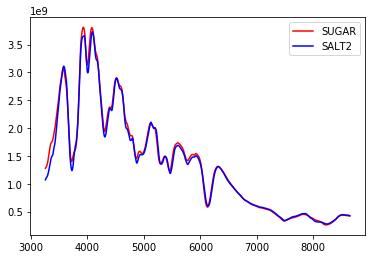

In [64]:
plt.plot(wavel, band_flux_sugar, label='SUGAR', c='r')
plt.plot(wavel, band_flux_salt2, label='SALT2', c='b')
plt.legend()
plt.show()